<a href="https://colab.research.google.com/github/jleugr/k/blob/main/k_clt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

try:
  import google.colab
  %pip install git+https://github.com/ksachdeva/rethinking-tensorflow-probability.git
except:
  pass
from rethinking.mcmc import sample_posterior
from rethinking.data import dataframe_to_tensors #delete if not useful

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64
Root = tfd.JointDistributionCoroutine.Root
tf.compat.v1.enable_eager_execution()

  Cloning https://github.com/ksachdeva/rethinking-tensorflow-probability.git to /tmp/pip-req-build-d875in5d
  Running command git clone -q https://github.com/ksachdeva/rethinking-tensorflow-probability.git /tmp/pip-req-build-d875in5d
  Created wheel for rethinking: filename=rethinking-0.1.0-py3-none-any.whl size=8395 sha256=392c5fa28b786ca147ecff4ba4dc0452a7fed1fa6618992100ba2b851fce1803
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ald20o4/wheels/04/4c/71/5c37bbbd5c6b8ebc6a2321d702f0624acca75badffdfbed543
Successfully built rethinking


In reference [1], a formula for affect of air density on a baseball is given:

$K= \frac{1}{2} \frac{pA}{m}$

Where $A$ is the area of the baseball, $m$ is the mass of the baseball, and $p$ is the air density.\
This project subsitutes the humid air density $\rho$ for $p$. A formula for humid air density [2] is:

$\rho = \frac{p_{d}M_{d}+p_{v}M_{v}}{RT}$

Where $p_d$ is the partial pressure of dry air\
$P_v$ is the pressure of water vapor\
$M_d$ is the molecular mass of dry air\
$M_v$ is the molecular mass of water vapor, and\
$RT$ is the universal gas constant $R$ multiplied by the standard temperature $T$ in Kelvins

Note all variables except temperature and height are in Pascals (PA). These values are all given below with the addition of $L1$ which is the standard temperature lapse rate at heights above sea level between 0 and 1100 meters and $pa$ which is the static air pressure corresponding to the same height.[3]

In [ ]:
#no edit needed
#all values are in millimeters
#approximate area and mass of a baseball 
b_a=tf.constant([27.2619], dtype=tf.float32)
b_d=tf.constant([70.2697], dtype=tf.float32)

#this stuff are assorted variables for the air density formulas, see reference for more info.
#gravity
g=tf.constant([9.81], dtype=tf.float32)
#universal gas constant
rs=tf.constant([8.31446], dtype=tf.float32)
#molar mass of dry air
M=tf.constant([.028965], dtype=tf.float32)
#static pressure of dry air 
pa=tf.constant([101325.00], dtype=tf.float32)
#standard temperature in K (not to be confused with the local temperature)
t1=tf.constant([288.15], dtype=tf.float32)
#temperature lapse rate
l1=tf.constant([-0.0065], dtype=tf.float32)
#molar mass of water vapor
Mv=tf.constant([0.018016], dtype=tf.float32)


This section includes the elevation of the UNCC college baseball park measured at home plate. We also simulate some values for humidity and temperature. Because the college baseball season is so long, we want to simulate values for home games during the month of March.\
The next thing we are doing here is finding the partial air density at the park. This is a constant value:

$p=pa[{\frac{T+(h_b-h)*L1}{T}}]^{\frac{-gM_d}{RL1}}$

Where $h_b$ is the reference height for the standard air pressure which i just 0 for us (and anyone else at an elevation under 11000 meters.) $L1$ is the temperature lapse rate at this height.

In [ ]:
#------
#uncc baseball ht = 184 m (probably)
ht=tf.constant([184.893], dtype=tf.float32)


tf.random.set_seed(5)

#humidity
hum=tf.random.uniform([4,20], minval=.2, maxval=.9, dtype=tf.float32)
#temp 
temp=tf.random.uniform([4, 20], 21., 0., dtype=tf.float32)

#local "observed" dry air pressure for this park
p= pa*(((t1+(ht-0)*l1)/(t1))**((-g*M)/(rs*l1)))

print(p)


tf.Tensor([99122.72], shape=(1,), dtype=float32)


In this code chunk we build the model we want to sample from.

The first 2 lines are prior distribution assumptions for humidity and temperature. I chose normal for humidity. The average humidity, according to google, is about 70% in March. In Charlote humidity doesn't seem to vary that much, so assumed that the variance was around .10.\
Temperature is a student T distribution. For temperature we can imagine the temperature might be between 32* and 70 degrees with a mean somewhere near 60. The variance for temperature was chosen after building several models and modifying until they sampled well. The degrees of freedom for this distribution are $N-1$ where N is the number of samples. We are going to take 5000 samples so we want 4999 DF.\
After that we have term1 and term2. Term1 is a formula for the saturation pressure of water:

$p_{sat}=6.1078 \times 10^{\frac{7.5*t}{t+237.3}}$

where $t$ is the local temperature in Celsius.

Term2 calculates the formula for the partial density of dry air $p_d$:

$p_{d}=p-p_{v}$ \
$p_{v}=\phi*p_{sat}$

Where $\phi$ is the relative humidity $(0 \leq \phi \leq 1$) and $p$ is the observed density of dry air, 99122.72. \

The next line calculates mu=$\rho$ which is what we want to find a distribution of values for. We then put all this into an exponential distribution ("ph") with rate=$\rho=mu$$. Our full model is therefore:

$p_{h} \sim exp(\rho)$\
$\rho=\frac{p_{d}M_{d}+p_{v}M_{v}}{RT}$\
$p_d = 99122.72-{hum} \times p_{sat}$\
$p_sat=6.1078 \times 10^{\frac{7.5*temp}{temp+237.3}}$\
$temp \sim T(4999, 17.09, 1.2)$\
$hum \sim N(.70, .09)$


\



*so we don't have to use more than one saturation pressure formula 

In [ ]:
def model_p():
    def _generator():
        #humidity
        hum_pr = yield Root(tfd.Sample(tfd.Normal(0.70, .09, name="hum"), 
                                       sample_shape=(1))) 
        #temp
        temp_pr =  yield Root(tfd.Sample(tfd.StudentT(4999, 17.09, 1.21, name="temp"), 
                                         sample_shape=(1)))

        #calculates the saturation pressure of water 
        term1=((6.1078*10**((7.5*temp_pr[...,tf.newaxis])/(temp_pr[...,tf.newaxis]+237.3))))

        #calculates partial pressure of dry air
        term2 = (99122.72-(hum_pr[...,tf.newaxis] * term1[...,tf.newaxis]))

        #calculates the total density of humid air 
        mu=((1/2395.8115)*(((term2[...,tf.newaxis])*.028965)+
                           ((hum_pr[...,tf.newaxis] * term1)*0.018016)))
        #exponential distribution for ph
        ph = yield tfd.Independent(
            tfd.Exponential(mu), reinterpreted_batch_ndims= 3    
        )
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)
jdc = model_p()

next we can look at a sample from our model to get an idea how it's behaving before we move on. This takes some explaining:

first recall all values are in PA which to make sense of them we need to convert to in/hg\
second note that the dry air pressure for this park (99122.72 PA) is equivalent to 743.48143565 mm of mercury which is the same as 29.79 in/hg (normal barometric pressure metric we see on weather.com)\
third it's nice to know that the average barometric pressure for charlotte nc in march is about 30 in/hg.\
I set up the model to print values we are calculating. It returns these and also returns 3 other variables.

ok so\
the first 2 printouts we are getting are samples of air pressures (not to be confused with air density, what we want to actually measure.) we can verify that these make sense pretty easily.\
the first value is the value calcualted in term1, "the saturation vapor pressure of water". this value generally returns a number under around 15-20 PA which is (assuming saturation vapor pressure can be meaningfully translated to barometric pressure) the equivalent of around .5 barometric inches.\
the second value returns the partial pressure of dry air. this is the observed absolute pressure (99122.72) minus the saturation pressure. This value is pretty close to the absolute pressure as we would expect.\
the third value is the humid air density (not air pressure!) calculated from these values. this is not something we can easily think about in terms of real life. it usually returns a value within 10 decimal places of .6 which when you translate to IN/hg is a very small number. we can assume this is calculating correctly since the other two are numbers that make sense. It should in theory go be higher when the temperature and air pressure are low. 

The values returned as tensors seem to be for var0, var1 sampled values of hum and temp. var3 is the probability of mu given these values. We can tell because it goes down if the model samples a day when it's 40 degrees outside and up if the model samples a day when its 60 degrees. 

In [ ]:
jdc.sample()


Tensor("mul_1:0", shape=(1, 1), dtype=float32)
Tensor("sub:0", shape=(1, 1, 1), dtype=float32)
Tensor("mul_6:0", shape=(1, 1, 1, 1), dtype=float32)
tf.Tensor([[23.487411]], shape=(1, 1), dtype=float32)
tf.Tensor([[[99104.516]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor([[[[1.1982955]]]], shape=(1, 1, 1, 1), dtype=float32)


StructTuple(
  var0=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.77495575], dtype=float32)>,
  var1=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([20.073421], dtype=float32)>,
  var2=<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[0.6165806]]]], dtype=float32)>
)

this is the various parts of the model sampler. it works more like a neural network than BRMS does:

first you have to define the initial state for the sampler. Because MCMC is in effect a calculus problem where we are measuring the movement of a frictionless particle I like to think of this section as like choosing the initial position of the imaginary particle. 0 is an option but it makes more sense I think to choose the current state of the model which is why we select a random sample from jdc.sample() just like when we were looking at it earlier.

Next thing we see is something called 'bijectors.' These are bijective functions because we aren't solving this problem using the "observed data", we are solving a numerically similar problem in our probability model. Basically bijectors are the same thing as a smoothing kernel. I chose identity because I don't want the data transformed too much but there are other options that might be familiar to NN/ML people like tanh, softmax, etc. 

Last thing in this block is the actual model sampler. This one is pretty much self explanitory. 

In [ ]:
#warning before running:
#sometimes if you run more than 2-3x in a row the entire model will fail. this is also something that happens in standard tf and pytorch. 
#if this happens, reset the runtime and run the whole thing over from the top.

#------------

#num. chains for MCMC, initial values for temp, humidity
NUM_CHAINS_FOR_m = 4

hum_p_in, temp_p_in,  _ = jdc.sample()
#initial state
init_state = [
    tf.tile(hum_p_in, (NUM_CHAINS_FOR_m,)),
    tf.tile(temp_p_in, (NUM_CHAINS_FOR_m,)),
]

#bijectors
bijectors = [
    tfb.Identity(),
    tfb.Identity(),
]
#sampler
posterior_m, trace_m= sample_posterior(
    jdc,
    observed_data=(hum,temp),
    params=["hum", "temp"],
    init_state=init_state,
    bijectors=bijectors,
    num_samples=5000,
)


tf.Tensor([[22.417553]], shape=(1, 1), dtype=float32)
tf.Tensor([[[99105.305]]], shape=(1, 1, 1), dtype=float32)
tf.Tensor([[[[1.1982992]]]], shape=(1, 1, 1, 1), dtype=float32)
Tensor("mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/JointDistributionCoroutine_CONSTRUCTED_AT_top_level/log_prob/mul_1:0", shape=(4, 1), dtype=float32)
Tensor("mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/JointDistributionCoroutine_CONSTRUCTED_AT_top_level/log_prob/sub:0", shape=(4, 4, 1), dtype=float32)
Tensor("mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstr

model summary gives a somewhat higher rhat for temperature than I would personally like (1.02-1.04 depending) but this is about as good as it's gonna get I suspect. Using real data might improve it but for now I don't think it's that big of a deal.

In [ ]:
#model summary

az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hum,0.703,0.089,0.544,0.875,0.004,0.003,569.0,1186.0,1.00
temp,16.945,1.269,14.510,19.405,0.154,0.109,70.0,75.0,1.04


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce52adce90>,
      dtype=object)

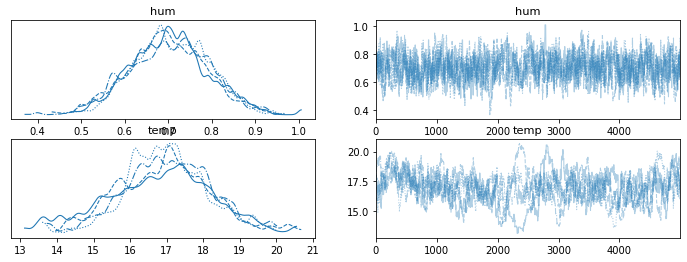

In [ ]:
az.plot_trace(trace_m, filter_vars="like")

A few simulated values from the model for humidity and temperature, we can just look and see if these are reasonable or not. 

In [ ]:
hum_sim = trace_m.posterior["hum"].values[0]
print("humidity values= ", hum_sim[1:10])

temp_sim = trace_m.posterior["temp"].values[0]
print("temperature values", temp_sim[1:10])


humidity values=  [0.70641845 0.70641845 0.7065553  0.721649   0.68954766 0.72727644
 0.72281927 0.72281927 0.72281927]
temperature values [17.144855 17.144855 17.017517 17.293392 17.300537 17.550491 17.557709
 17.557709 17.557709]


generates humid air density values (in PA) from humidity and temperature values

In [ ]:
def ph_from_samples_2(hum_sim, temp_sim):
        term1=((6.1078*10**((7.5*temp_sim[...,tf.newaxis])/(temp_sim[...,tf.newaxis]+237.3))))


        term2 = (99122.72-(hum_sim[...,tf.newaxis] * term1))


        mu=((1/2395.8115)*(((term2*.028965)+(hum_sim[...,tf.newaxis] * term1)*0.018016)))

        return mu

ph_sim=ph_from_samples_2(hum_sim, temp_sim)
print("air density values=", ph_sim[1:10])
print(tf.size(ph_sim))

air density values= [[1.1983156]
 [1.1983156]
 [1.1983161]
 [1.1983137]
 [1.1983166]
 [1.198312 ]
 [1.1983125]
 [1.1983125]
 [1.1983125]]
tf.Tensor(5000, shape=(), dtype=int32)


a note on the air density values:\
whether these are correct or not is hard to tell because just the air density alone isnt something people measure and put online. something called 'air density ceiling' is easily available but how exactly these are related to each other is more work than I want to put in just now.\
Anyway this next block just uses the simulated values for the air density and calculates the effect on a baseball.

In [ ]:
k=(ph_sim/2)*(b_a/b_d)
print(k[0:10])
K=np.array(k)
K.flatten()

tf.Tensor(
[[0.23244989]
 [0.23244984]
 [0.23244984]
 [0.23244993]
 [0.23244947]
 [0.23245002]
 [0.23244916]
 [0.23244925]
 [0.23244925]
 [0.23244925]], shape=(10, 1), dtype=float32)


the rest of this is just some manipulation so this will plot more easily.\
first plot is just k~air density. this is obviously linear and as we expect higher air density means more of an effect on the baseball. in "real life" (a differential equation for trajectory) this would reflect as higher drag and lift coefficients.

Text(0, 0.5, 'air density')

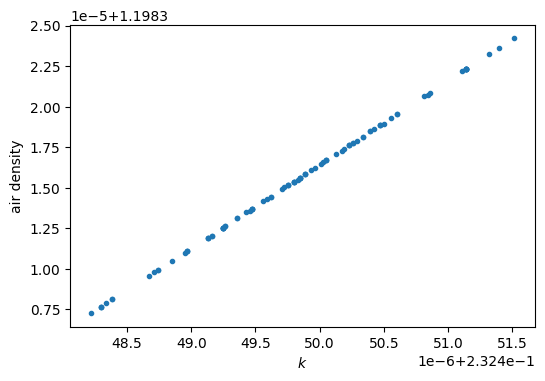

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(k[0:100], ph_sim[0:100], marker=".")
ax.set_xlabel('$k$')
ax.set_ylabel('air density')


we can also look at how humidity and temperature affect K. This is nice because we expect air to be denser and K to be higher when the humidity is low. We can see that this is happening so our model is working appropriately. 

Text(0, 0.5, 'relative humidity')

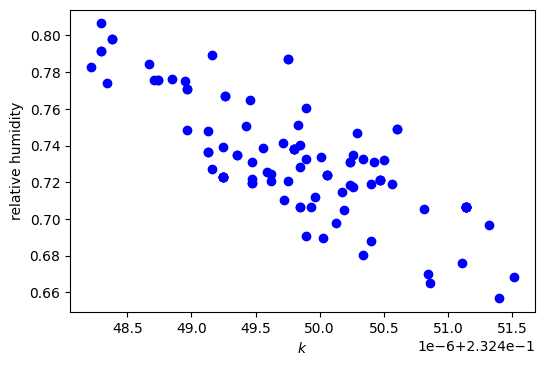

In [ ]:
fig, ax = plt.subplots(dpi=100)
#humidity and temp are a different size so using only the first 100 values of each
ax.scatter(k[0:100], hum_sim[0:100], color='b')
ax.set_xlabel('$k$')
ax.set_ylabel('relative humidity')

similarly for temperature, we expect with a lower temp a higher air density and for k to be higher. This is also what we can see going on in this plot although the affect is a little more scattered.

Text(0, 0.5, 'temperature')

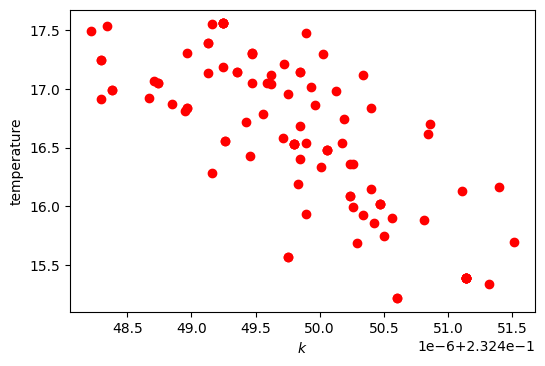

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(k[0:100], temp_sim[0:100], color='r')
ax.set_xlabel('$k$')
ax.set_ylabel('temperature')

References:


[1] Nathan, Alan. Analysis of Baseball Trajectories. 28 Aug. 2017, baseball.physics.illinois.edu/TrajectoryAnalysis.pdf.\
[2]“Density of Air.” Wikipedia, 17 June 2019, en.wikipedia.org/wiki/Density_of_air.\
[3]“Barometric Formula.” Wikipedia, 10 Mar. 2020, en.wikipedia.org/wiki/Barometric_formula#Density_equations.\

Code adapted from https://github.com/ksachdeva/rethinking-tensorflow-probability/tree/master/notebooks


In [ ]:
#writes dataset to csv (ignore)

#from google.colab import  drive
#only unmute drive.mount once or it gets mad and yells at u)
#drive.mount('/drive')

#pd.DataFrame(K).to_csv('/drive/My Drive/project_csvs/clt_k.csv')

Mounted at /drive
